<img src="../../../images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="left">

## _Debugging with Assertions_ 


The latest version of this notebook is available on: 

***
### Contributors
Emma Dasgupta, Lia Yeh

### Qiskit Package Versions

In [1]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.9.0.dev0+3bd8cb5',
 'qiskit-ignis': '0.2.0.dev0+7d28711',
 'qiskit-ibmq-provider': 'dev-1d446af2456c039aa9337e9e9ad05ea4630392af',
 'qiskit': None,
 'qiskit-aer': '0.3.0',
 'qiskit-aqua': None}

## Introduction
Once a quantum program has been written, it is important to check if it is correct. However, debugging quantum programs can be difficult because classical debugging approaches such as using print statements will not work since measurement disturbs state.

Using quantum assertions is a useful method for debugging quantum programs. This method allows us to put breakpoints at points in a program where we expect certain qubits to be in a certain state (for example, a classical state, a uniform superposition state, or a product state). Next, we can use statistical tests to check if the qubits are actually in the expected states.

Currently, we support assertions of classical states, uniform superposition states, product states, and the negation of each of these. 

In [2]:
# useful additional packages
import math
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# importing Qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute
from qiskit import BasicAer, IBMQ

# import basic plot tools
from qiskit.tools.visualization import plot_histogram

In [3]:
backend = BasicAer.get_backend('qasm_simulator') # run on local simulator by default

# Uncomment the following lines to run on a real device
#IBMQ.load_accounts()
#from qiskit.providers.ibmq import least_busy
#backend = least_busy(IBMQ.backends(operational=True, simulator=False))
#print("the best backend is " + backend.name())

## Bell State<a id='section1'></a>

Suppose we want to make a circuit that creates a bell state. We can use assertions to check if our program does what we expect.

First, we make an empty list to store all our breakpoints throughout the program. (This is useful if you later have multiple breakpoints and want to comment some out easily.)

In [4]:
breakpoints = []

We now initialize a circuit and apply a Hadamard gate to qubit 0:

In [5]:
#making circuit: bell state
qc = QuantumCircuit(2, 2)
qc.h(0)

Note that at this point in the program we expect qubit 1 and 0 to be in a product state. (Not entangled.)



In [6]:
breakpoints.append(qc.get_breakpoint_product(0, 0, 1, 1, 0.05))

Here, the first four inputs are qubit 0, cbit 0, qubit 1, cbit 1, indicating that we are asserting that qubit 0 and qubit 1 are in a product state, and we are storing our measurements of qubit 0 on cbit 0 and qubit 1 on cbit 1. The last argument is optional and represents the critical p-value that determines whether the statistical tests underlying this quantum assertion will pass or fail (default 0.05).

The breakpoint creates a copy of the quantum circuit up to this point with measurement operations at the end as visualized below. This will later be run on the backend to get an intermediate measurement distribution used for statistical tests to evaluate our assertion.

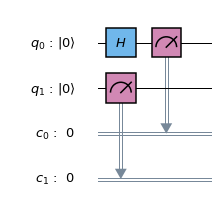

In [7]:
breakpoints[0].draw(output="mpl")

Our new breakpoint has now been added to the list of breakpoints and we can finish writing our program:

In [8]:
qc.cx(0, 1)
qc.measure([0,1], [0,1])

When executing the circuit, we add in the list of breakpoints to be executed as well:

In [9]:
# running the job, printing results
job_sim = execute(breakpoints + [qc], backend) #execute all breakpoints as well as the main quantum circuit
sim_result = job_sim.result()                  #obtain results object as before

Now using a classical Python assertion, we can check if our breakpoint passed the assertion of a uniform superposition state.

In [10]:
assert(sim_result.get_assertion_passed(breakpoints[0]))

If the assertion passes, then the program will continue running. If the assertion fails, the program will stop with an assertion error.

Since our assertion passes, we conclude that we did not make an error in creating the state at the breakpoint.

You can access the p-value, chi squared statistic and whether or not a test passed for the statistical test within each assertion as well:

In [15]:
print("breakpoint0 pval =")

print("\n"+ "breakpoint0 chisq =")

print("\n"+"breakpoint0 passed?")

breakpoint0 pval =

breakpoint0 chisq =

breakpoint0 passed?


As before, we can still draw our original circuit and view its results. (Breakpoints not shown.)

In [ ]:
qc.draw(output="mpl")

In [ ]:
plot_histogram(sim_result.get_counts(qc))

We see that we have created a bell state. 

In a longer program, we could place breakpoints in the middle of a program after multiple instructions in a more useful manner to check if we have correctly implemented the gates in our circuit.


## QFT<a id='section1'></a>

Here is an example of using assertions in a quantum fourier transform circuit:

Initialize breakpoints list:

In [ ]:
breakpoints = []

Continue writing the program:

In [14]:
#make the qft
def input_state(circ, n):
    """n-qubit input state for QFT that produces output 1."""
    for j in range(n):
        circ.h(j)
        circ.u1(-math.pi/float(2**(j)), j)

def qft(circ, n):
    """n-qubit QFT on q in circ."""
    for j in range(n):
        for k in range(j):
            circ.cu1(math.pi/float(2**(j-k)), j, k)
        circ.h(j)

qft3 = QuantumCircuit(5, 5, name="qft3")
qft4 = QuantumCircuit(5, 5, name="qft4")
qft5 = QuantumCircuit(5, 5, name="qft5")

# Below, qft3 is a 3-qubit quantum circuit.
input_state(qft3, 3) # Initializes the state so that post-QFT, the state should be 1.

Insert a breakpoint to the qft3 circuit after initializing the input state:

In [ ]:
breakpoint1 = qft3.get_breakpoint_uniform(range(3), range(3), 0.05)

This asserts that the 3 qubits are in uniform superposition, with critical p-value 0.05.

Continue the program:

In [ ]:
qft3.barrier()
qft(qft3, 3)
qft3.barrier()

Insert a breakpoint after the quantum Fourier Transform has been performed:

In [ ]:
breakpoint2 = qft3.get_breakpoint_classical(range(3), range(3), 0.05, 1)

This asserts that the 3 qubits are a classical value of 1, with critical p-value 0.05.

Continuing, we measure necessary qubits before calling execute:

In [ ]:
for j in range(3):
    qft3.measure(j, j)

input_state(qft4, 4)
qft4.barrier()
qft(qft4, 4)
qft4.barrier()
for j in range(4):
    qft4.measure(j, j)

input_state(qft5, 5)
qft5.barrier()
qft(qft5, 5)
qft5.barrier()
for j in range(5):
    qft5.measure(j, j)

Add the list of breakpoints to the circuits being run in execute:

In [ ]:
# setting up the backend, running the breakpoint and the job
sim_backend = BasicAer.get_backend('qasm_simulator')
job = execute(breakpoints + [qft3, qft4, qft5], sim_backend, shots=1024)
result = job.result()

We can now see the results of our assertions:

In [ ]:
# Show the assertion
breakpoints = [breakpoint1, breakpoint2]
print()
for breakpoint in breakpoints:
    print("Results of our " + result.get_assertion_type(breakpoint) + " Assertion:")
    tup = result.get_assertion(breakpoint)
    print('chisq = %s\npval = %s\npassed = %s\n' % tuple(map(str,tup)))
    assert ( result.get_assertion_passed(breakpoint) )

As well as the outputs of our original quantum circuits:

In [ ]:
# Show the results
print(result.get_counts(qft3))
print(result.get_counts(qft4))
print(result.get_counts(qft5))